In [9]:
from train import *
from test import *
from layers import *
from utils import *
from loss import *
from metric import *
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers

In [10]:
data_microbioma_train, data_microbioma_test, data_domain_train, data_domain_test, \
otu_columns, domain_columns = read_data()

# Autoencoder Bioma Bioma

In [11]:
def model(shape, input_transform, output_transform, layers_list, latent_space, activation_fn):
    return autoencoder(domain_shape=None, 
                       bioma_layers=layers_list, 
                       latent_space=latent_space,
                       input_transform=input_transform,
                       output_transform=output_transform,
                       activation_function_encoder=activation_fn,
                       activation_function_decoder=activation_fn,
                       activation_function_latent=activation_fn)

def compile_model(model, optimizer, reconstruction_error, input_transform, output_transform):
    metrics = get_experiment_metrics(input_transform, output_transform)[0][3:]
    model.compile(optimizer=optimizer, loss=reconstruction_error, metrics=metrics)

In [12]:
latent_space = 100
def model_fn():
    m, e, _, d = model(shape=717,
                      input_transform=CenterLogRatio(),
                      output_transform=None,
                      layers_list=[256,128],
                      latent_space=latent_space,
                      activation_fn='tanh')
    
    compile_model(model=m,
                  optimizer=optimizers.Adam(lr=0.001),
                  reconstruction_error=LossMeanSquaredErrorWrapper(CenterLogRatio(), None),
                  input_transform=CenterLogRatio,
                  output_transform=None)
    return m, e, None, d

In [13]:
results, models = train(model_fn,
                        data_microbioma_train,
                        data_domain_train,
                        latent_space=latent_space,
                        folds=5,
                        epochs=100,
                        batch_size=64,
                        learning_rate_scheduler=None,
                        verbose=-1)

<p>Best iteration: <b>52</b></p>

<b>loss</b>: 1.9757 (min: 1.9657, max: 1.9862)

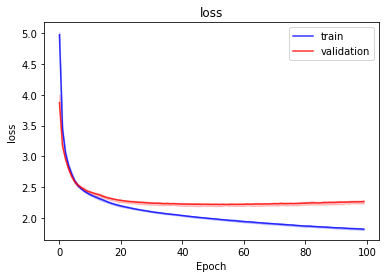

<b>bioma_BrayCurtis</b>: 0.9987 (min: 0.9987, max: 0.9987)

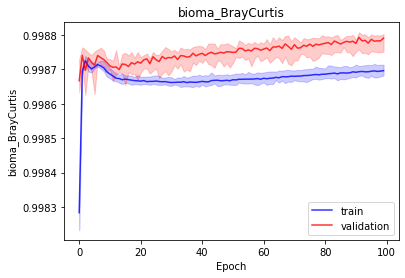

<b>bioma_pearson_corr</b>: 0.3485 (min: 0.3478, max: 0.3493)

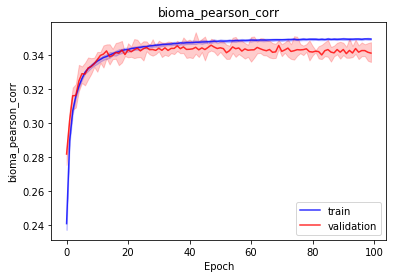

<b>bioma_jensen_shannon_divergence</b>: nan (min: nan, max: nan)

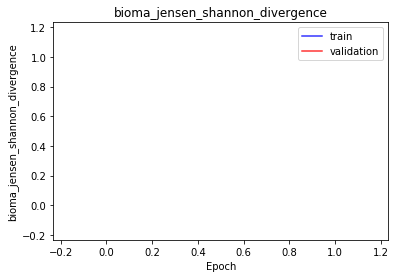

| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| loss | 1.9757440392647783 | 1.965681440442564 | 1.9862340586706317 |
| bioma_BrayCurtis | 0.9986713528633118 | 0.9986616969108582 | 0.9986873865127563 |
| bioma_pearson_corr | 0.34851518273353577 | 0.3478069603443146 | 0.34933310747146606 |
| bioma_jensen_shannon_divergence | nan | nan | nan |


[('best_lost_epoch', 52),
 ('val_loss', [2.2175415328570773, 2.1894099031175887, 2.2345096383775984]),
 ('val_bioma_BrayCurtis', [0.99876136, 0.998733, 0.9987843]),
 ('val_bioma_pearson_corr', [0.34162325, 0.33797073, 0.34635264]),
 ('val_bioma_jensen_shannon_divergence', [nan, nan, nan])]

In [14]:
print_results(results)

In [15]:
def test_model(models, input_transform, output_transform):
    data_bioma_test_transformed = data_microbioma_test
    if input_transform is not None:
        input_transform = input_transform()
        data_bioma_test_transformed = input_transform(data_microbioma_test)
    if output_transform is not None:
        output_transform = output_transform()
    metrics_results = {}
    metrics = get_experiment_metrics(input_transform, output_transform)[0][3:]
    otus_errors = []
    all_predictions = []
    for cv_models in models:
        model, model_encoder, _, _ = cv_models
        predictions = model.predict(data_microbioma_test)
        all_predictions.append(predictions)
        for m in metrics:
            if m.name not in metrics_results:
                metrics_results[m.name] = []
            result = m(data_microbioma_test, predictions)
            m.reset_states()
            metrics_results[m.name].append(result.numpy())
        # otus error
        se = tf.math.squared_difference(predictions, data_bioma_test_transformed)
        mse = tf.reduce_mean(se, axis=0)
        otus_errors.append(mse)
    mse_otus = tf.reduce_mean(tf.stack(otus_errors, axis=0), axis=0)
    mse_otus_keys = sorted(zip(mse_otus.numpy(), otu_columns), key=lambda x: x[0])
    for k, v in list(metrics_results.items()):
        v = np.asarray(v)
        metrics_results[k] = (v.mean(), v.min(), v.max())
    
    md_text = "## Test results \n"
    md_text += "| Metric           | Mean    | Min     | Max     |\n"
    md_text += "|:-----------------|--------:|--------:|--------:|\n"
    for k, v in metrics_results.items():
        md_text += "| {} | {} | {} | {} |\n".format(k, v[0], v[1], v[2])


    display(Markdown(md_text))

    md_text ="### Best Otus\n"
    md_text += "| OTU | mse |\n"
    md_text += "|:----|----:|\n"
    for v, k in mse_otus_keys[:10]:
        md_text += "| {} | {} |\n".format(k, v)
    md_text += "\n\n"
    md_text +="### Worst Otus\n"
    md_text += "| OTU | mse |\n"
    md_text += "|:----|----:|\n"
    for v, k in reversed(mse_otus_keys[-10:]):
        md_text += "| {} | {} |\n".format(k, v)

    display(Markdown(md_text))
    
    final_predictions = np.mean(all_predictions,axis=0)
    
    return final_predictions

In [16]:
predictions = test_model(models, CenterLogRatio, None)
save_predictions(predictions, 'experiment_autoencoder_bioma.txt')

## Test results 
| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| BrayCurtis | 0.2715207040309906 | 0.26995038986206055 | 0.27485036849975586 |
| pearson_corr | 0.8438930511474609 | 0.8405015468597412 | 0.8474021553993225 |
| jensen_shannon_divergence | 0.37838488817214966 | 0.36391523480415344 | 0.38616740703582764 |


### Best Otus
| OTU | mse |
|:----|----:|
| 238109 | 0.04882413521409035 |
| 216643 | 0.048887837678194046 |
| 242284 | 0.04889502376317978 |
| 769643 | 0.04889629781246185 |
| 883748 | 0.04898601025342941 |
| 584331 | 0.049136318266391754 |
| 11428 | 0.049194395542144775 |
| 585221 | 0.049369994550943375 |
| 833317 | 0.04939015954732895 |
| 137818 | 0.04988030716776848 |


### Worst Otus
| OTU | mse |
|:----|----:|
| 589597 | 6.605848789215088 |
| 336745 | 6.071669101715088 |
| 594013 | 5.9357733726501465 |
| 558264 | 5.270880699157715 |
| 553648 | 5.245184421539307 |
| 338140 | 5.035150051116943 |
| 536008 | 4.844961166381836 |
| 751138 | 4.798012733459473 |
| 591499 | 4.79005241394043 |
| 17991 | 4.672762393951416 |


In [17]:
encoders = []
decoders = []
for cv_models in models:
    model, encoder, _, decoder = cv_models
    encoders.append(encoder)
    decoders.append(decoder)
    
def make_cv_predictions(data, models):
    all_predictions = []
    for m in models:
        all_predictions.append(m.predict(data))
    return np.mean(all_predictions, axis=0)

# Single regresión from domain to encoded latent space

In [ ]:
targe_data = make_cv_predictions(data_microbioma_train, encoders)
test_data = make_cv_predictions(data_microbioma_test, encoders)

In [ ]:
def model(shape_in, shape_out, output_transform, layers_list, activation_fn):
    in_layer = layers.Input(shape=(shape_in,))
    net = in_layer
    for s in layers_list:
        net = layers.Dense(s, activation=activation_fn)(net)
    net = layers.Dense(shape_out, activation=None)(net)
    if output_transform is not None:
        net = output_transform(net)
    out_layer = net
    
    model = keras.Model(inputs=[in_layer], outputs=[out_layer], name='model')
    return model

def compile_model(model, optimizer, reconstruction_error, input_transform, output_transform):
    metrics = get_experiment_metrics(input_transform, output_transform)[0][3:]
    model.compile(optimizer=optimizer, loss=reconstruction_error, metrics=metrics)

# Domain-Bioma 

In [ ]:
def model(shape_in, shape_out, output_transform, layers_list, activation_fn):
    in_layer = layers.Input(shape=(shape_in,))
    net = in_layer
    for s in layers_list:
        net = layers.Dense(s, activation=activation_fn)(net)
    net = layers.Dense(shape_out, activation=None)(net)
    if output_transform is not None:
        net = output_transform(net)
    out_layer = net
    
    model = keras.Model(inputs=[in_layer], outputs=[out_layer], name='model')
    return model

def compile_model(model, optimizer, reconstruction_error, input_transform, output_transform):
    metrics = get_experiment_metrics(input_transform, output_transform)[0][3:]
    model.compile(optimizer=optimizer, loss=reconstruction_error, metrics=metrics)

In [ ]:
def model_fn():
    m = model(shape_in=36,
              shape_out=717,
              output_transform=None,
              layers_list=[128,256],
              activation_fn='tanh')
    
    compile_model(model=m,
                  optimizer=optimizers.Adam(lr=0.001),
                  reconstruction_error=LossMeanSquaredErrorWrapper(CenterLogRatio(), None),
                  input_transform=CenterLogRatio,
                  output_transform=None)
    return m, None, m, None

In [ ]:
results, models = train(model_fn,
                        data_microbioma_train,
                        data_domain_train,
                        latent_space=latent_space,
                        folds=5,
                        epochs=100,
                        batch_size=64,
                        learning_rate_scheduler=None,
                        verbose=-1)

In [ ]:
print_results(results)

In [ ]:
def test_model(models, input_transform, output_transform):
    data_bioma_test_transformed = data_microbioma_test
    if input_transform is not None:
        input_transform = input_transform()
        data_bioma_test_transformed = input_transform(data_microbioma_test)
    if output_transform is not None:
        output_transform = output_transform()
    metrics_results = {}
    metrics = get_experiment_metrics(input_transform, output_transform)[0][3:]
    otus_errors = []
    all_predictions = []
    for cv_models in models:
        model, _, _, _ = cv_models
        predictions = model.predict(data_domain_test)
        all_predictions.append(predictions)
        for m in metrics:
            if m.name not in metrics_results:
                metrics_results[m.name] = []
            result = m(data_microbioma_test, predictions)
            m.reset_states()
            metrics_results[m.name].append(result.numpy())
        # otus error
        se = tf.math.squared_difference(predictions, data_bioma_test_transformed)
        mse = tf.reduce_mean(se, axis=0)
        otus_errors.append(mse)
    mse_otus = tf.reduce_mean(tf.stack(otus_errors, axis=0), axis=0)
    mse_otus_keys = sorted(zip(mse_otus.numpy(), otu_columns), key=lambda x: x[0])
    for k, v in list(metrics_results.items()):
        v = np.asarray(v)
        metrics_results[k] = (v.mean(), v.min(), v.max())
    
    md_text = "## Test results \n"
    md_text += "| Metric           | Mean    | Min     | Max     |\n"
    md_text += "|:-----------------|--------:|--------:|--------:|\n"
    for k, v in metrics_results.items():
        md_text += "| {} | {} | {} | {} |\n".format(k, v[0], v[1], v[2])


    display(Markdown(md_text))

    md_text ="### Best Otus\n"
    md_text += "| OTU | mse |\n"
    md_text += "|:----|----:|\n"
    for v, k in mse_otus_keys[:10]:
        md_text += "| {} | {} |\n".format(k, v)
    md_text += "\n\n"
    md_text +="### Worst Otus\n"
    md_text += "| OTU | mse |\n"
    md_text += "|:----|----:|\n"
    for v, k in reversed(mse_otus_keys[-10:]):
        md_text += "| {} | {} |\n".format(k, v)

    display(Markdown(md_text))
    
    final_predictions = np.mean(all_predictions,axis=0)
    return final_predictions

In [ ]:
predictions = test_model(models, CenterLogRatio, None)
save_predictions(predictions, 'experiment_linear_regresion.txt')

# Autoencoder-like from domain

In [ ]:
def model_fn():
    m = model(shape_in=36,
              shape_out=717,
              output_transform=None,
              layers_list=[128, 100, 128, 256],
              activation_fn='tanh')
    
    compile_model(model=m,
                  optimizer=optimizers.Adam(lr=0.001),
                  reconstruction_error=LossMeanSquaredErrorWrapper(CenterLogRatio(), None),
                  input_transform=CenterLogRatio,
                  output_transform=None)
    return m, None, m, None

In [ ]:
results, models = train(model_fn,
                        data_microbioma_train,
                        data_domain_train,
                        latent_space=latent_space,
                        folds=5,
                        epochs=100,
                        batch_size=64,
                        learning_rate_scheduler=None,
                        verbose=-1)

In [ ]:
print_results(results)

In [ ]:
predictions = test_model(models, CenterLogRatio, None)
save_predictions(predictions, 'experiment_fake_domain_autoencoder.txt')